In [2]:
file_prefix <- "ch17.3"
reuse_fit <- T
source("preset.R")

In [3]:
data <- read_csv("data/IncomeFamszState3yr.csv", comment = "#") %>% 
  mutate(State = factor(State)) %>% 
  mutate(state_id = as.integer(State)) 
  #filter(state_id <= 10)

# for inverse mapping
state_map <- data %>% select(State, state_id) %>% distinct()

stan_data <- list(
  N = nrow(data), 
  Y = data$MedianIncome, 
  X = data$FamilySize, 
  W = data$SampErr, 
  G = data$state_id, 
  NG = n_distinct(data$State) 
)

Parsed with column specification:
cols(
  FamilySize = col_double(),
  State = col_character(),
  MedianIncome = col_double(),
  SampErr = col_double()
)



In [4]:
init <- function() {
  list(
    m_a0 = 40000, 
    m_a1 = 20000, 
    m_a2 = -2000
  )
}
fit <- stan(file = "model/ch17.3.stan", data = stan_data, seed = 123, init = init, 
            chains = 4, warmup = 1000, iter = 11000, thin = 2)

Warning message:
“There were 2168 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


In [5]:
save(fit, file = save_file_name("fit"))
load(file = save_file_name("fit"))

In [ ]:
#ggs_traceplot(ggs(fit, family = "m_a", inc_warmup = F))
# ggmcmc(ggs(fit), file = plot_file_name("diag")) # skip, because of file size.

In [7]:
res <- fit_to_tibble(fit)

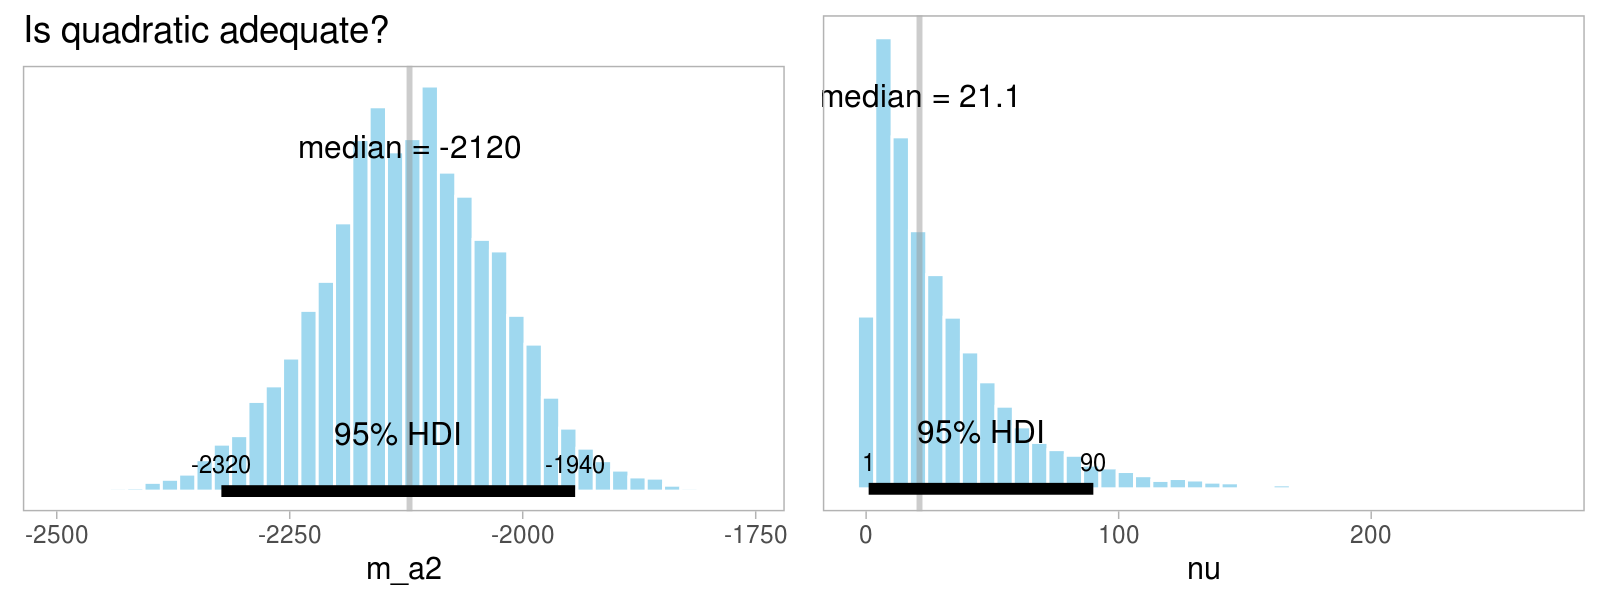

In [16]:
set_plot_size(8, 3)
# posteria
grid.arrange(
    grobs = list(plot_post(res, "m_a2", title = "Is quadratic adequate?"), 
                 plot_post(res, "nu")), 
    ncol = 2
)

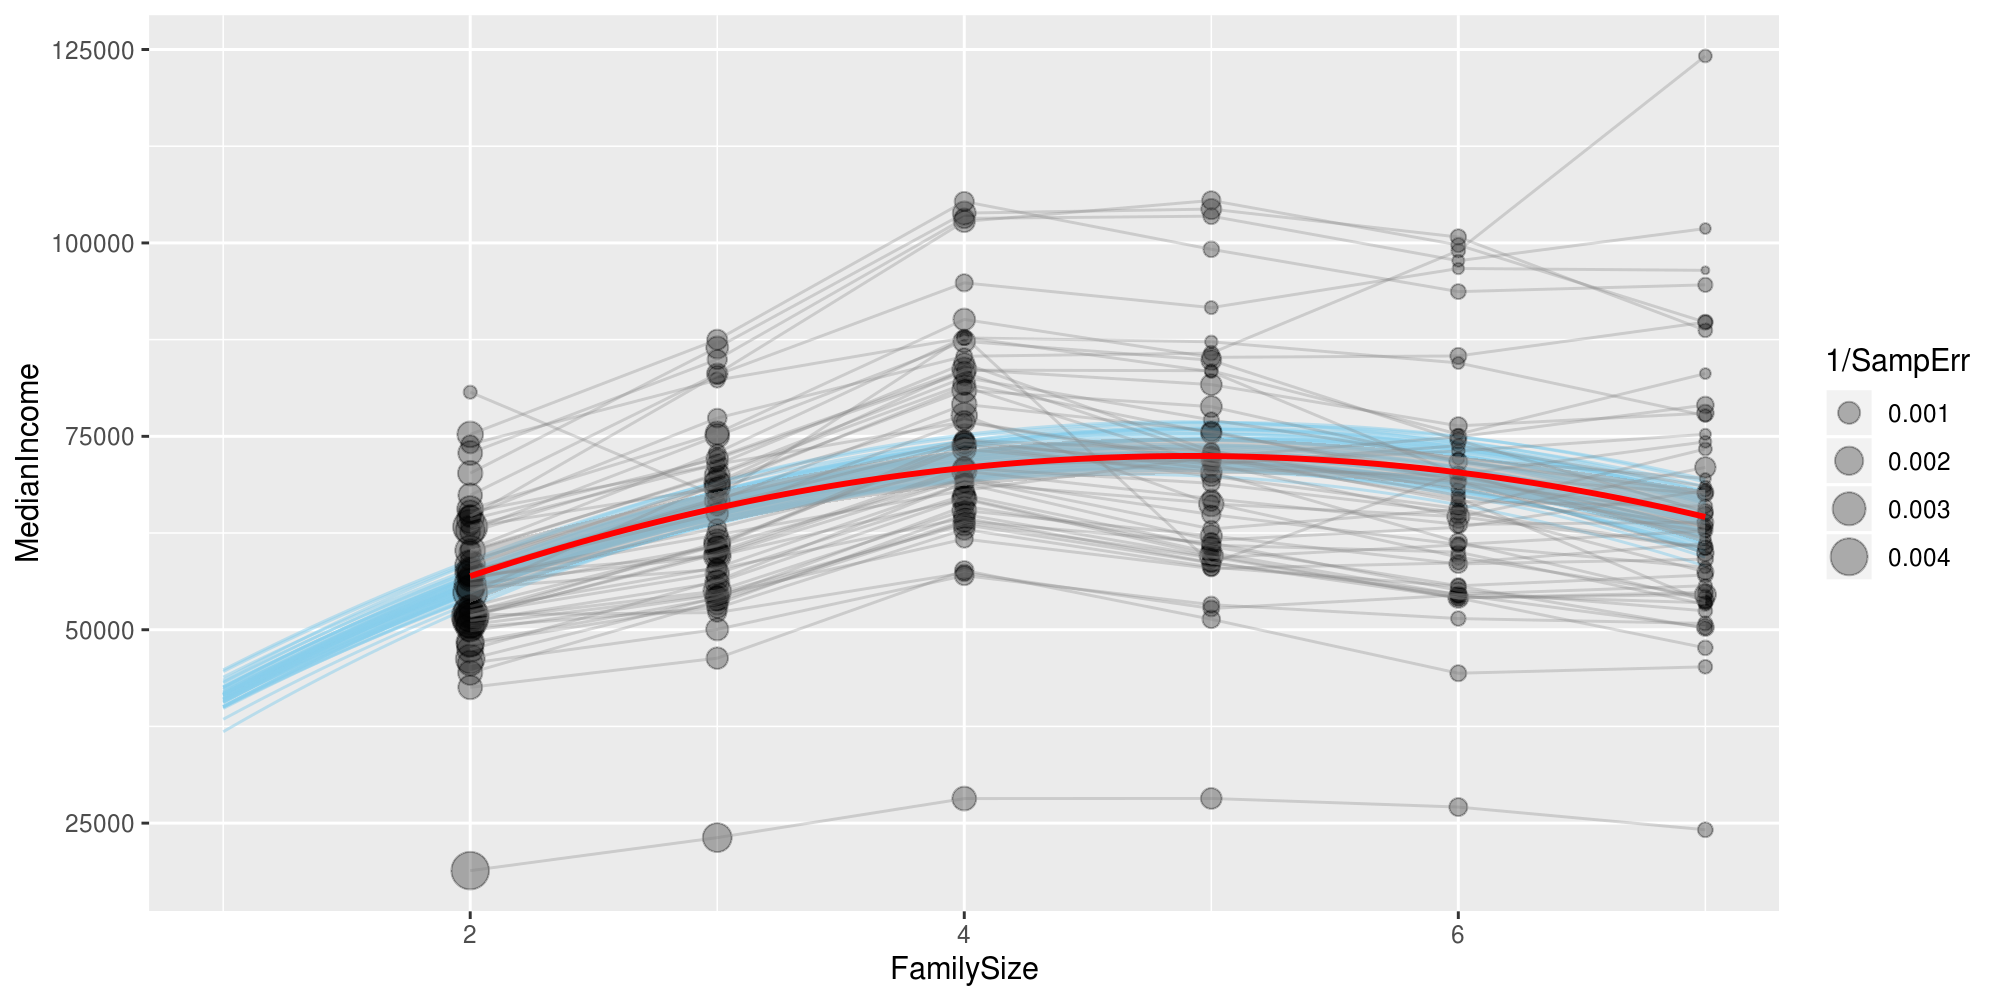

In [20]:
# total plot with m_a0, m_a1, m_a2
set_plot_size(10, 5)
res %>% 
  make_sample_grid(c(1, 7), x_name = "FamilySize", num_line = 50) %>% 
  mutate(MedianIncome = m_a0 + m_a1 * FamilySize + m_a2 * FamilySize ^ 2) %>% 
  ggplot(aes(FamilySize, MedianIncome)) +
    geom_line(aes(group = id), color = "skyblue", alpha = 0.5) + 
    geom_point(data = data, aes(size = 1.0 / SampErr), alpha = 0.3) + 
    geom_line(data = data, aes(group = state_id), color = "grey50", alpha = 0.3) + 
    geom_smooth(data = data, method = "lm", formula = y ~ poly(x, 2), color = "red") + 
    labs(size = "1/SampErr")

In [22]:
# state-wise plot with a0[.], a1[.], a2[.]
plot_state_wise_predictive <- function(state_ids) {
  res %>% 
    make_sample_grid(c(1, 7), x_name = "FamilySize") %>% 
    multi_gather(starts_with("a"), col_name = "state_id") %>% 
    mutate(MedianIncome = a0 + a1 * FamilySize + a2 * FamilySize ^ 2) %>% 
    filter(state_id %in% state_ids) %>% 
    left_join(state_map, by = "state_id") %>% 
    ggplot(aes(FamilySize, MedianIncome)) + 
      geom_line(aes(group = id), color = "skyblue", alpha = 0.5) +
      geom_point(data = filter(data, state_id %in% state_ids), aes(size = 1.0/SampErr)) +
      facet_wrap(~State, ncol = 5) + 
      labs(size = "1/SampErr")
}

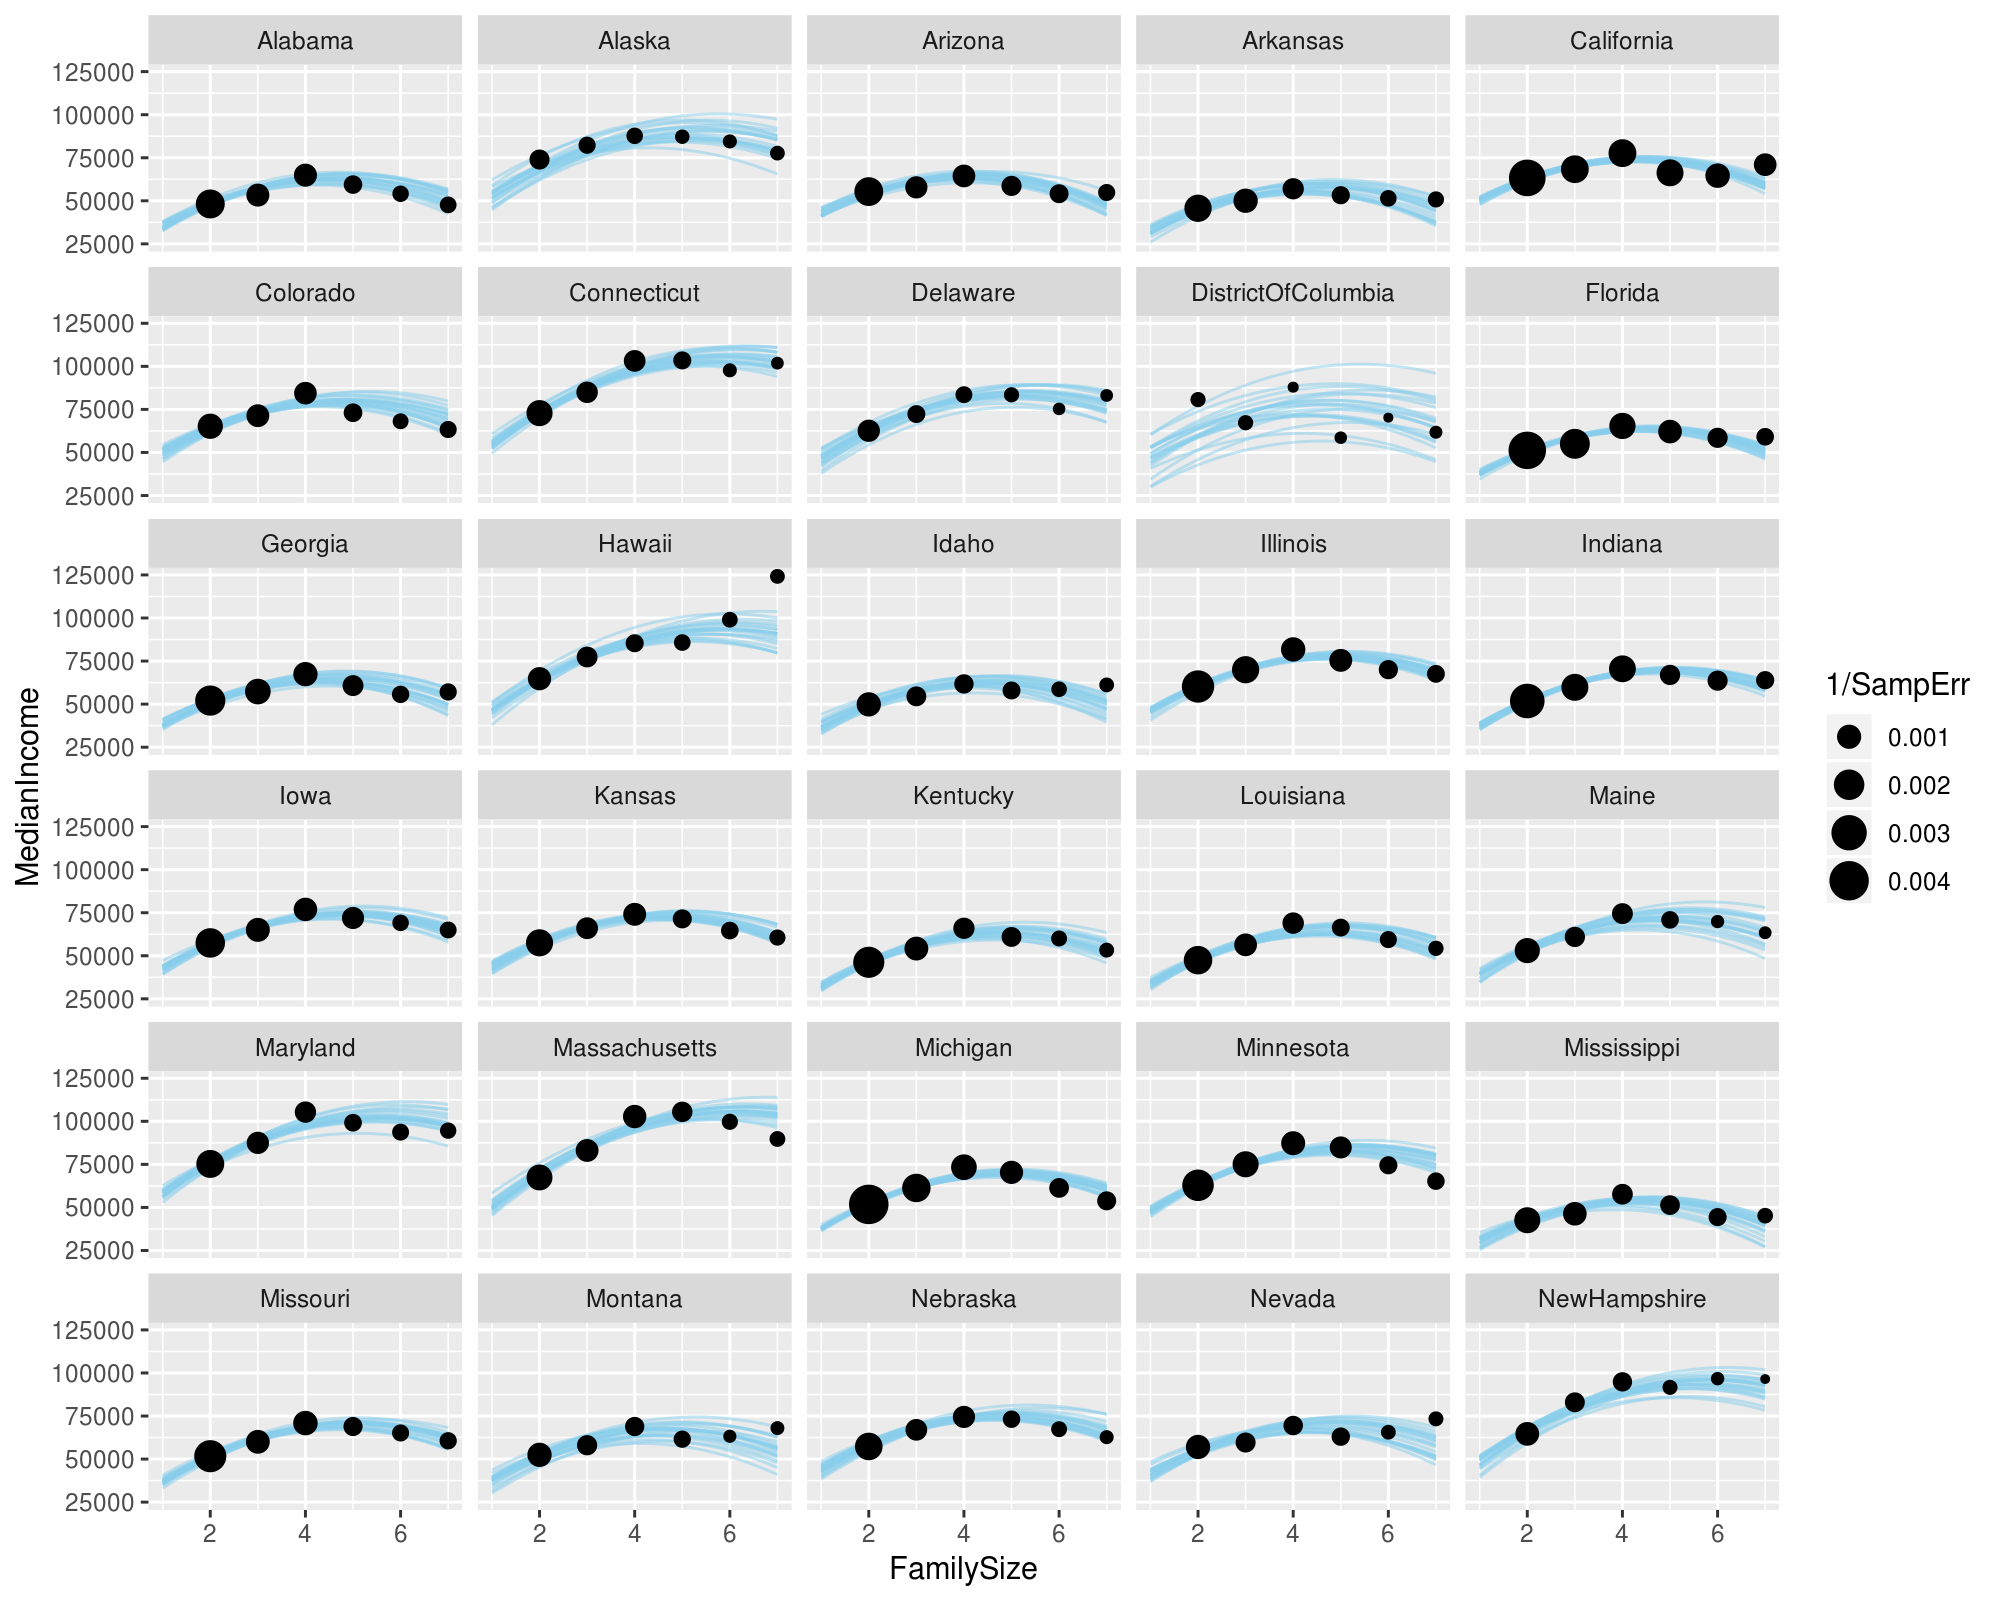

In [24]:
set_plot_size(10, 8)
plot_state_wise_predictive(seq(1, 30, by = 1))

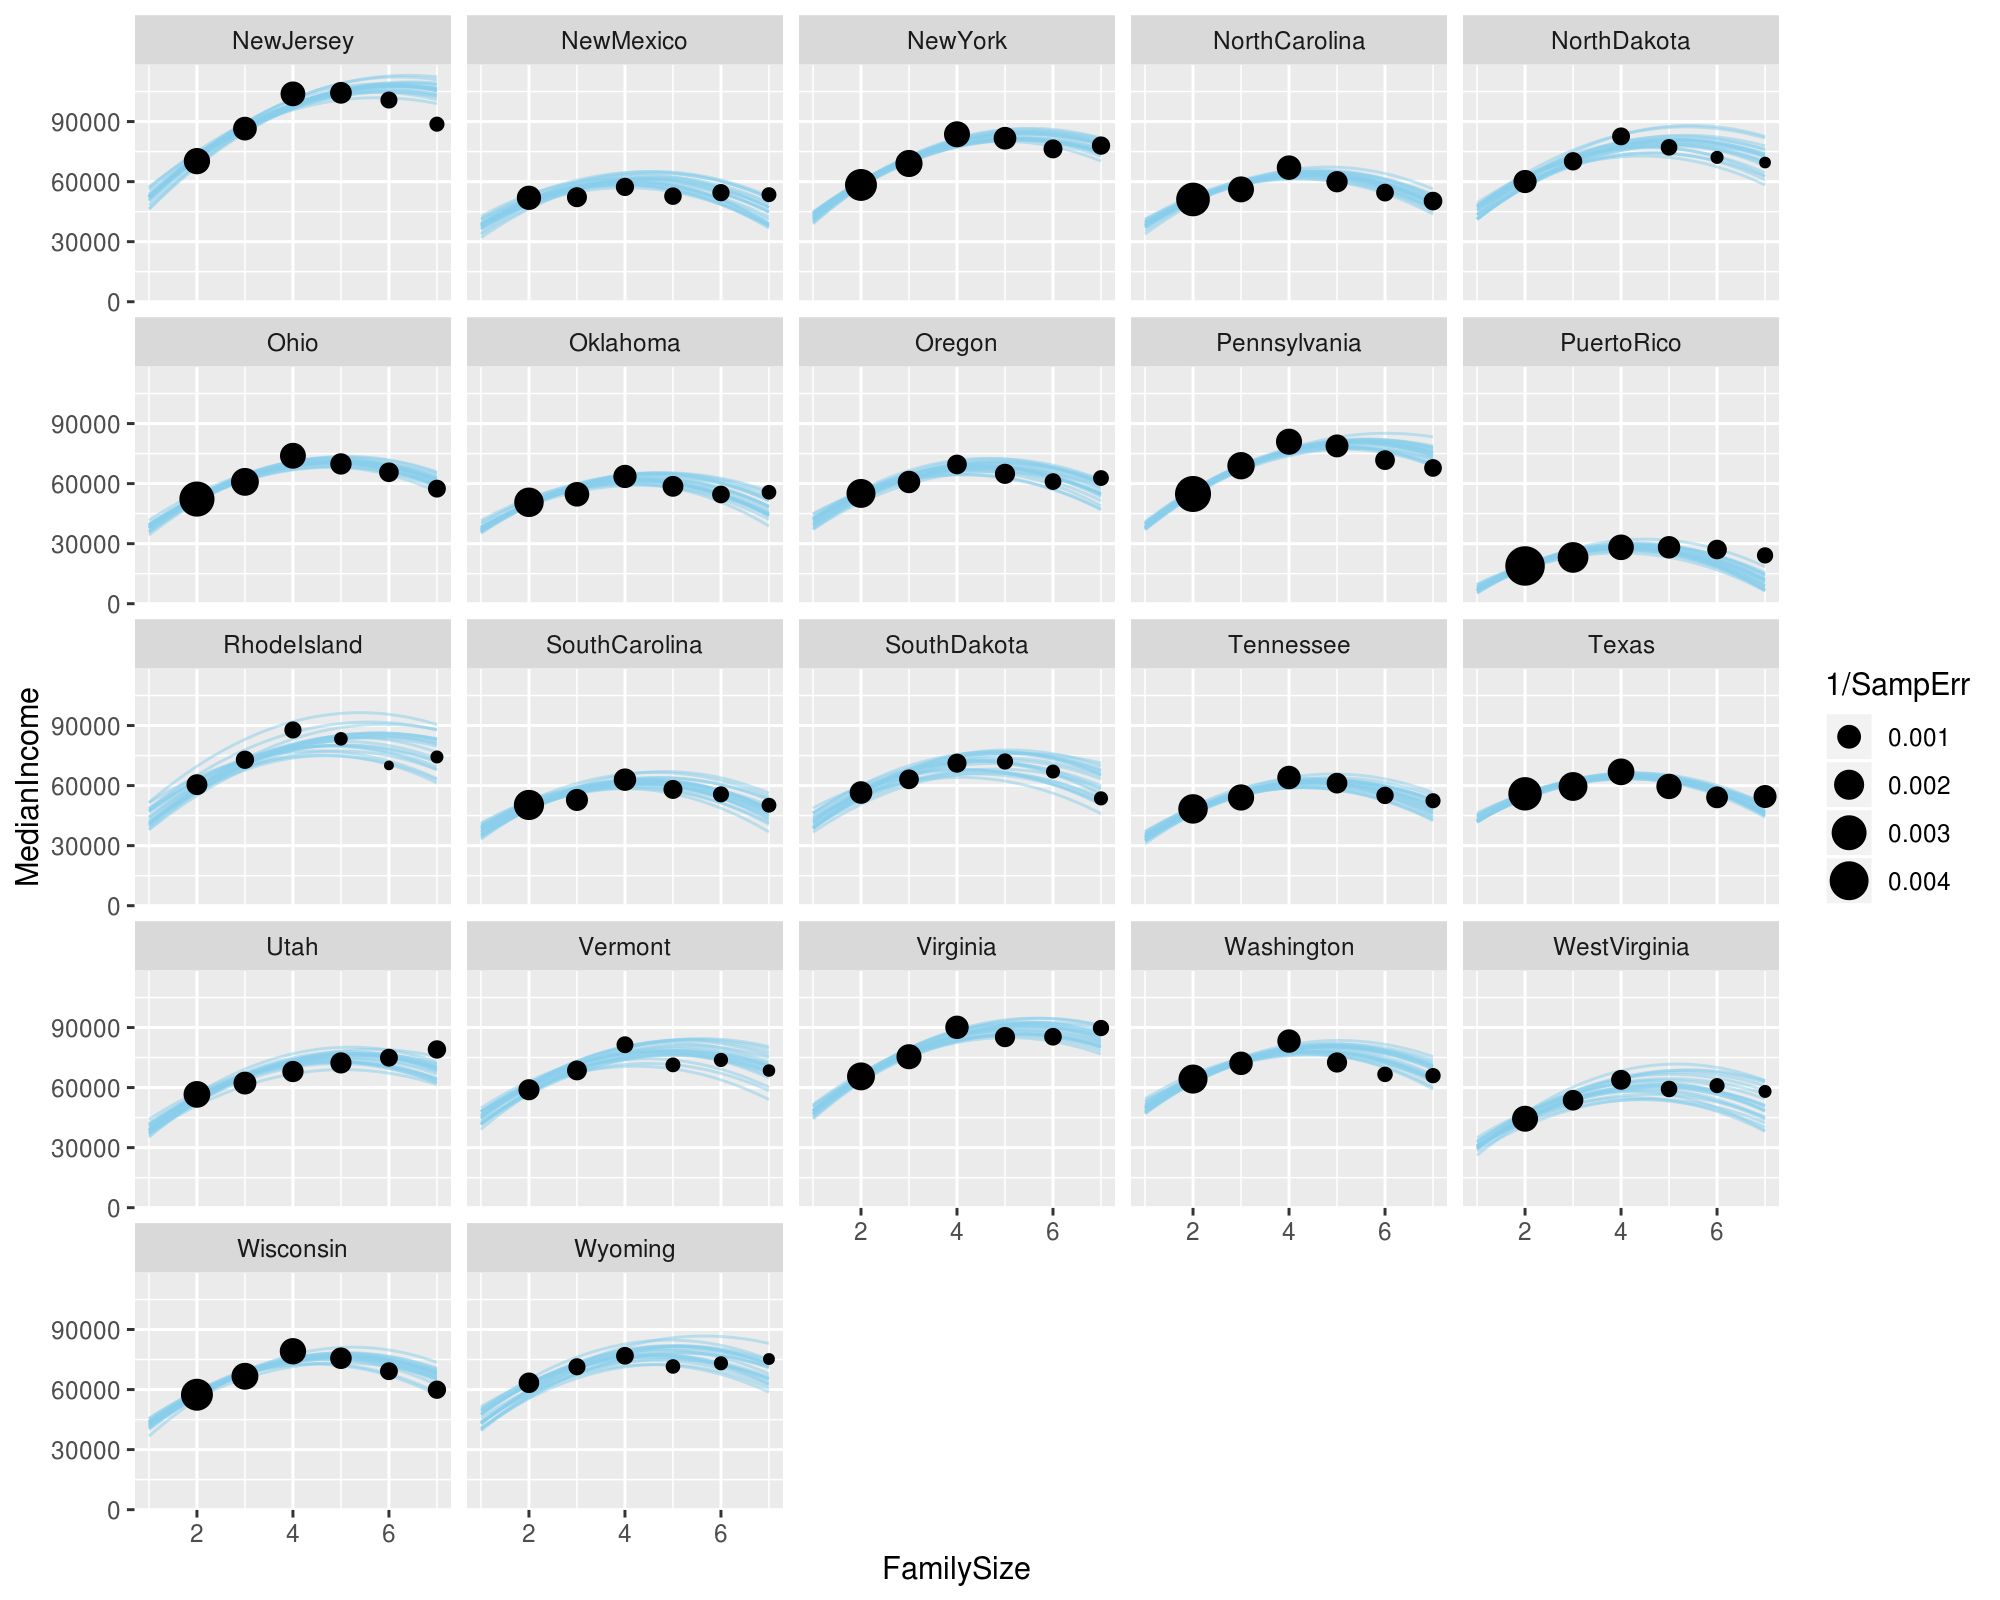

In [25]:
plot_state_wise_predictive(seq(31, 60, by = 1))